<a href="https://colab.research.google.com/github/larissa-rangel/Espectro/blob/main/ClimateDataV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Propriedade de estudo

Fontes:

https://eemont.readthedocs.io/en/latest/

https://developers.google.com/earth-engine/guides/reducers_image_collection

In [ ]:
!pip install geemap
!pip install eemont

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eemont: filename=eemont-0.3.6-py3-none-any.whl size=135742 sha256=62544f7f137644fdcbdc52f9b93affcf1d84f8c8c02d605d33a3be77f6081da4
  Stored in directory: /root/.cache/pip/wheels/c2/79/2c/4fed17c3d3b466bbf4fe5872eec11f189147043b01152a4f75
  Created wheel for ee_extra: filename=ee_extra-0.0.15-py3-none-any.whl size=236756 sha256=e8719adcd9e52d69901a285ad780f4fc8ad89ea18a91b61db97cabb00e987842
  Stored in directory: /root/.cache/pip/wheels/29/96/0e/4e36b0dfd85e16867723df739294c0aa45a65b191adac4d959
Successfully built eemont ee_extra


In [ ]:
import ee
from datetime import datetime
import geemap
import matplotlib.pyplot as plt
import eemont
import pandas as pd
import numpy as np
import seaborn as sns

# Trigger the authentication flow.
ee.Authenticate()
# Inicializar a API Earth Engine
ee.Initialize(project = 'mimetic-shape-410218')

In [ ]:
# Carregar a região
regiao = ee.FeatureCollection('projects/ee-l247008/assets/3')
#regiao = ee.FeatureCollection('projects/ee-l247008/assets/sorriso_MT_soja_2022').filter(ee.Filter.eq('Classes',39))
#regiao = ee.FeatureCollection('projects/ee-l247008/assets/MT_Municipios_2022').filter(ee.Filter.eq('NM_MUN','Sorriso'))

In [ ]:
# Dados do ERA5 (aplicar um tipo de pré-processamento as imagens)
dataset = (ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
           .filterBounds(regiao)
           .filterDate('2017-01-01', '2023-12-31')
           .select(['total_evaporation_sum', 'total_precipitation_sum',
                    'surface_net_solar_radiation_sum','surface_net_thermal_radiation_sum',
                    'temperature_2m_max','temperature_2m_min'])) #.limit(1000)

# Verificar se há máscara de nuvens
print('Quantidade de imagens:', dataset.size().getInfo())

Quantidade de imagens: 2555


In [ ]:
ts = dataset.getTimeSeriesByRegions(collection = regiao,
                                    bands = ['total_evaporation_sum', 'total_precipitation_sum',
                                            'surface_net_solar_radiation_sum','surface_net_thermal_radiation_sum',
                                            'temperature_2m_max','temperature_2m_min'],
                                    reducer = [ee.Reducer.mean()],
                                    scale = 11132)

In [ ]:
tsPandas = geemap.ee_to_df(ts)

In [ ]:
#tsPandas = geemap.ee_to_df(ts)
tsPandas[tsPandas == -9999] = np.nan
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)
tsPandas["total_evaporation_sum"] *= -1000
tsPandas["total_precipitation_sum"] *= 1000
tsPandas['temperature_2m_max'] -= 273.15
tsPandas['temperature_2m_min'] -= 273.15
tsPandas["temperature_2m_mean"] = ((tsPandas['temperature_2m_max']+tsPandas['temperature_2m_min'])/2)
tsPandas['surface_net_solar_radiation_sum'] *=1e-6
tsPandas['surface_net_thermal_radiation_sum'] *=1e-6
tsPandas["radiation"] = (tsPandas['surface_net_solar_radiation_sum'] - tsPandas['surface_net_thermal_radiation_sum'])
tsPandas = tsPandas.dropna()

In [ ]:
tsPandas

,Name,altitudeMo,begin,date,descriptio,end,extrude,icon,reducer,surface_net_solar_radiation_sum,surface_net_thermal_radiation_sum,temperature_2m_max,temperature_2m_min,tessellate,timestamp,total_evaporation_sum,total_precipitation_sum,visibility,temperature_2m_mean,radiation
0,3_A,,,2017-01-01,,,0,,mean,15.649826,-3.268466,29.444666,21.600702,1,,4.074117,4.695705,-1,25.522684,18.918292
3,3_A,,,2017-01-02,,,0,,mean,16.318286,-3.598656,28.190332,21.323831,1,,4.097781,7.498186,-1,24.757082,19.916942
6,3_A,,,2017-01-03,,,0,,mean,19.589566,-3.976208,29.518320,21.593866,1,,4.857818,12.348282,-1,25.556093,23.565774
9,3_A,,,2017-01-04,,,0,,mean,19.343444,-4.073058,29.652292,21.286356,1,,4.564105,14.045107,-1,25.469324,23.416502
12,3_A,,,2017-01-05,,,0,,mean,22.965970,-4.134086,30.967996,21.854089,1,,6.478842,0.615443,-1,26.411043,27.100056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7650,3_A,,,2023-12-26,,,0,,mean,19.767848,-5.675672,33.252679,22.271188,1,,2.587203,2.666551,-1,27.761934,25.443520
7653,3_A,,,2023-12-27,,,0,,mean,22.155470,-6.083534,32.291879,21.602243,1,,3.057336,0.664029,-1,26.947061,28.239004
7656,3_A,,,2023-12-28,,,0,,mean,22.266078,-6.763262,33.669992,22.043146,1,,2.596834,0.152588,-1,27.856569,29.029340
7659,3_A,,,2023-12-29,,,0,,mean,23.499826,-7.141128,36.128793,24.393396,1,,2.143255,0.006604,-1,30.261095,30.640954


<Axes: xlabel='date', ylabel='Value'>

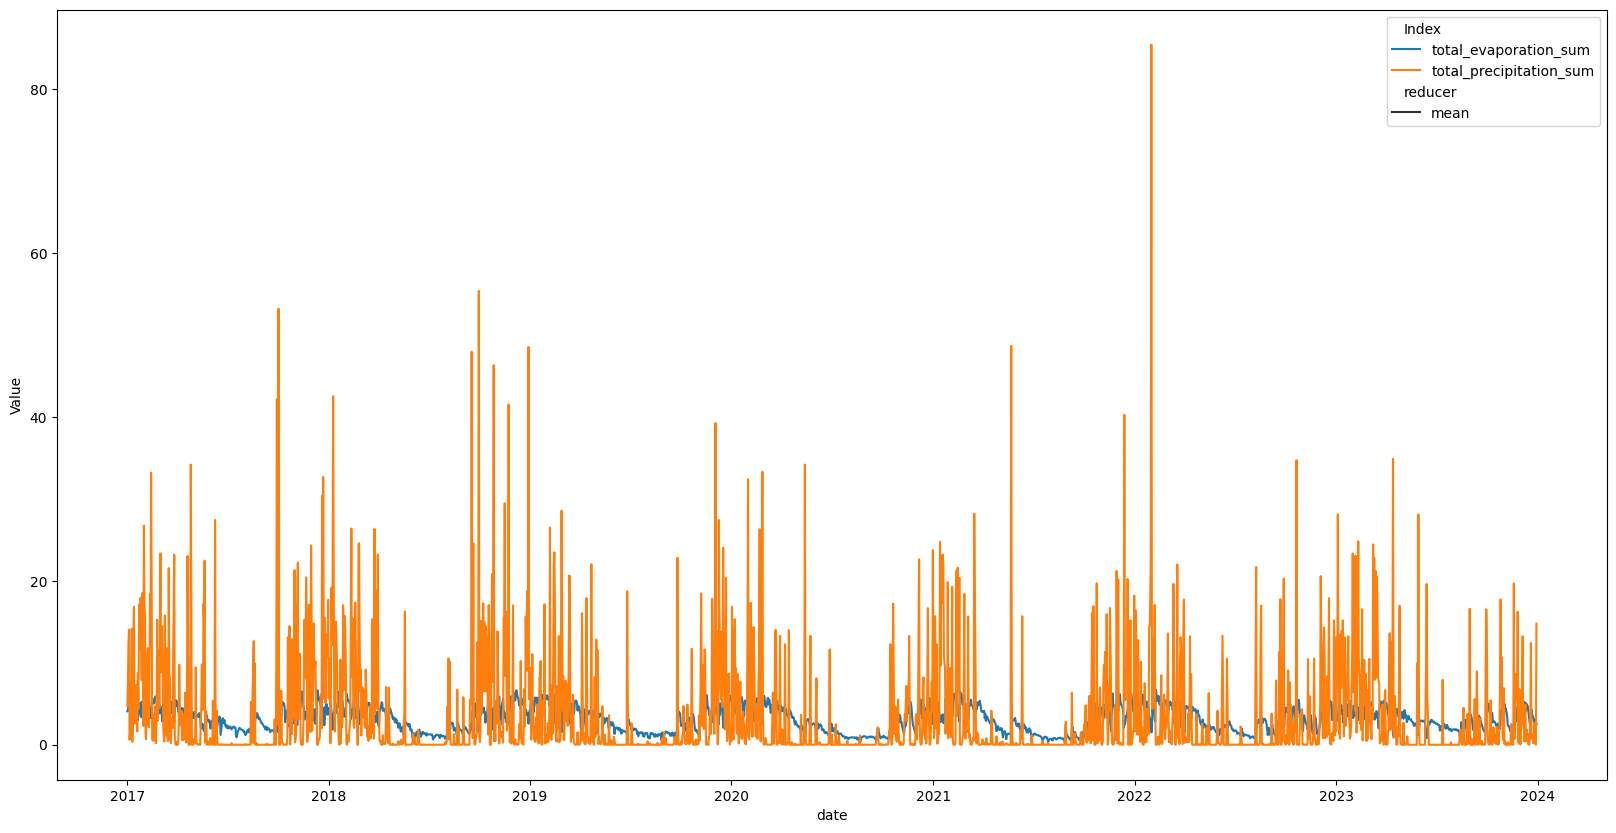

In [ ]:
plot = pd.melt(tsPandas,
                   id_vars = ['reducer','date'],
                   value_vars = ['total_evaporation_sum','total_precipitation_sum'],
                   var_name = 'Index',
                   value_name = 'Value')

plt.figure(figsize = (20,10))
sns.lineplot(data = plot,
             x = 'date',
             y = 'Value',
             hue = 'Index',
             style = 'reducer')

<Axes: xlabel='date', ylabel='Value'>

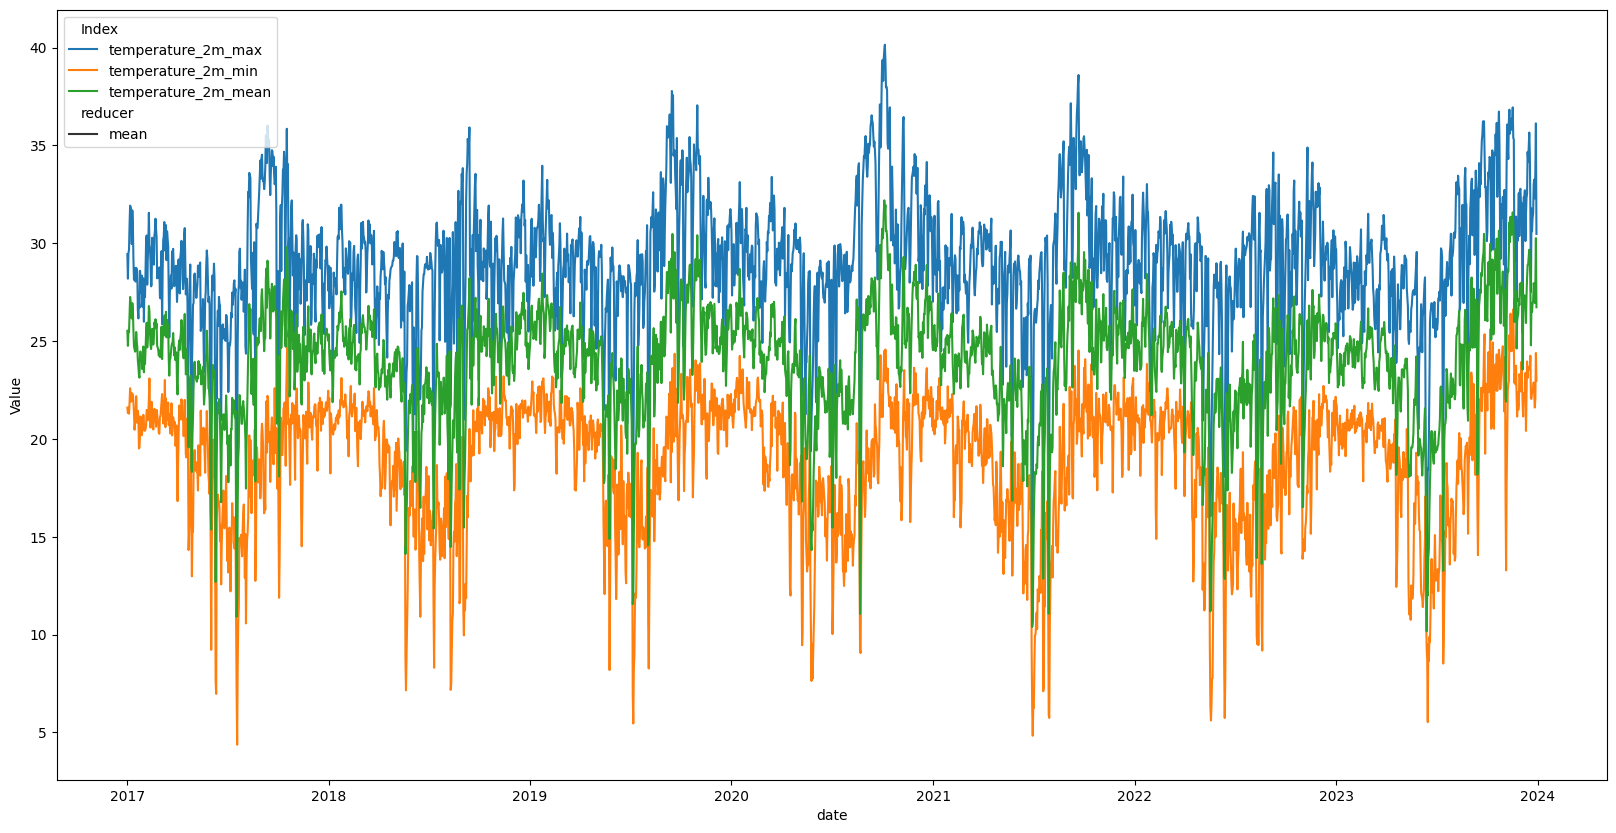

In [ ]:
plot1 = pd.melt(tsPandas,
                   id_vars = ['reducer','date'],
                   value_vars = ['temperature_2m_max',	'temperature_2m_min','temperature_2m_mean'],
                   var_name = 'Index',
                   value_name = 'Value')

plt.figure(figsize = (20,10))
sns.lineplot(data = plot1,
             x = 'date',
             y = 'Value',
             hue = 'Index',
             style = 'reducer')

<Axes: xlabel='date', ylabel='Value'>

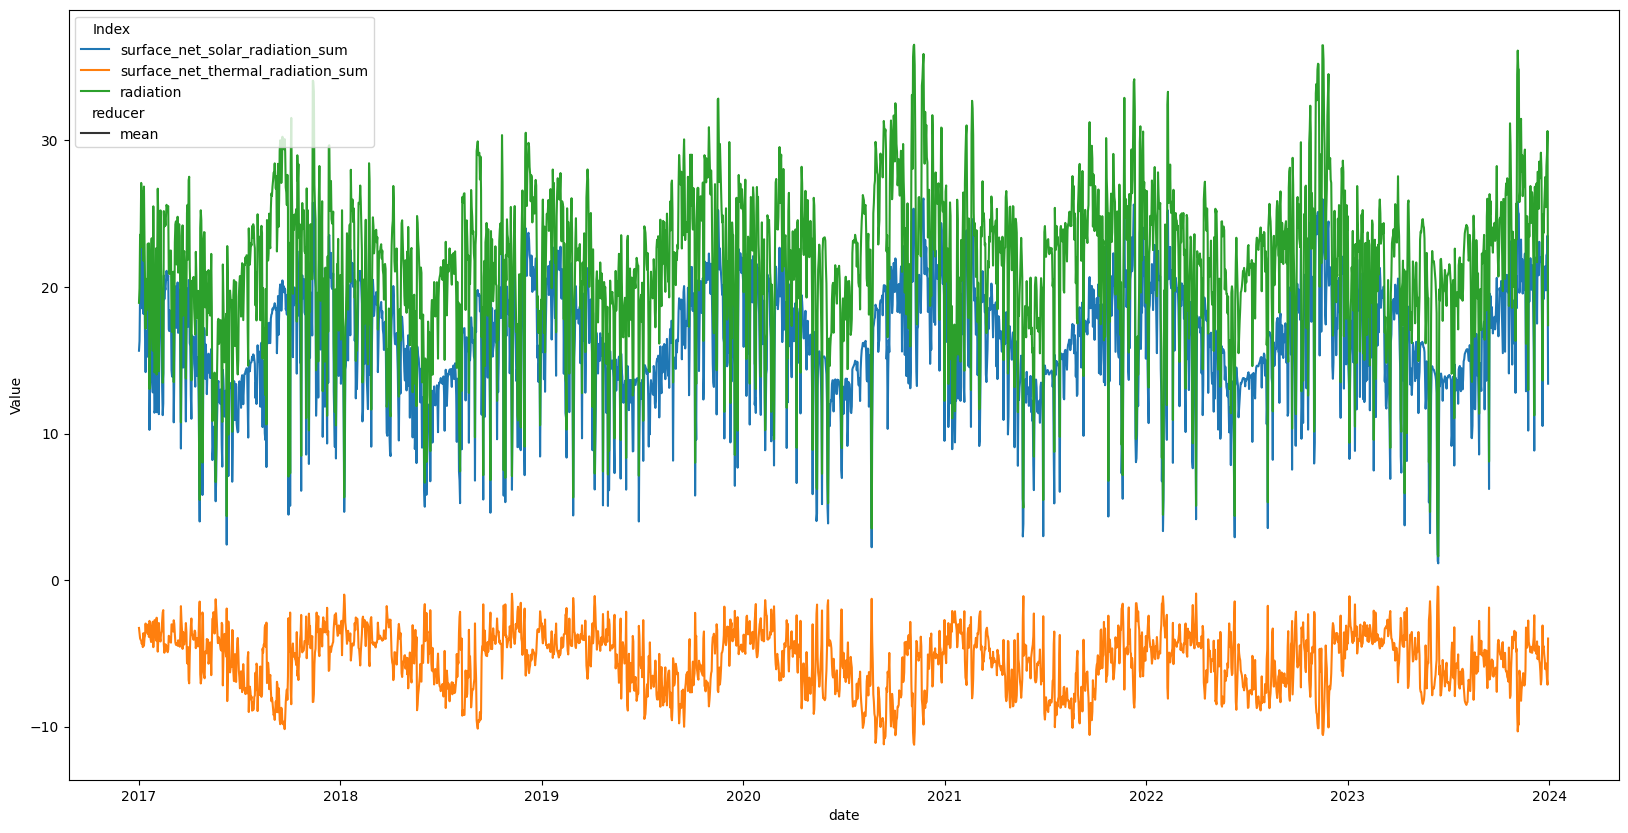

In [ ]:
plot2 = pd.melt(tsPandas,
                   id_vars = ['reducer','date'],
                   value_vars = ['surface_net_solar_radiation_sum',	'surface_net_thermal_radiation_sum', 'radiation'],
                   var_name = 'Index',
                   value_name = 'Value')

plt.figure(figsize = (20,10))
sns.lineplot(data = plot2,
             x = 'date',
             y = 'Value',
             hue = 'Index',
             style = 'reducer')